![SolasAI Banner Image](../images/SolasAI-Logo.png)

<br>

# SolasAI NYC Employment Bias Testing

## About

In this notebook we will cover the following:

- Importing Data
- Performing the Analysis
	- Scoring impact ratio
	- Selection impact ratio
- Conclusion

The SolasAI Disparity and Bias Testing Library includes functionality designed to comply with the testing requirements of the New York City Automated Employment Decision Tools ordinance [Local Law 144](https://legistar.council.nyc.gov/LegislationDetail.aspx?ID=4344524&GUID=B051915D-A9AC-451E-81F8-6596032FA3F9
) and accompanying [regulations](https://rules.cityofnewyork.us/wp-content/uploads/2023/04/DCWP-NOA-for-Use-of-Automated-Employment-Decisionmaking-Tools-2.pdf).


*This text and associated software do not represent and should not be construed as providing legal advice or requirements for regulatory compliance.*

In [1]:
import solas_disparity as sd
import pandas as pd
import numpy as np

# Import Data

In [2]:
df = pd.read_csv('data/employment.csv.gz')

In [3]:
df.head()

,Race/Ethnicity,Gender,Score,Selection
0,Black,Female,0.923733,1
1,Hispanic,Female,0.621700,0
2,Two or More Races,Male,0.772939,1
3,Native Hawaiian,Male,0.728608,1
4,Two or More Races,Male,0.990000,1


In [4]:
import pandas as pd
import numpy as np
from typing import List, Optional, Tuple

def create_dummies(
    group_data: pd.DataFrame, columns: List[str], prefix: Optional[str] = "", replace_unknown=True, unknown_value="Unknown"
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Function to create dummies and return as DataFrame and List of modified columns
    """

    # Create a copy of the DataFrame to avoid modifying the original one
    df_copy = group_data.copy()

    # Dictionary to store the unique values of each column
    unique_values = {}
    modified_columns = []

    for column in columns:
        # Replace 'unknown' with np.nan if replace_unknown is True
        if replace_unknown:
            df_copy[column] = df_copy[column].replace(unknown_value, np.nan)

        # Store the unique values of the column (excluding np.nan)
        unique_values[column] = df_copy[column].dropna().unique()

        # Add the unique values to the list of modified columns
        modified_columns.extend([prefix + value for value in unique_values[column]])

    # Perform one-hot encoding without creating additional columns for NaN values
    df_encoded = pd.get_dummies(df_copy, columns=columns, prefix_sep='', prefix=prefix)

    for column in columns:
        # Find the indices of rows where the original column was 'unknown'
        unknown_indices = df_copy[df_copy[column].isna()].index

        # Create a Boolean mask to select the encoded columns corresponding to the original column
        mask = df_encoded.columns.isin(unique_values[column])

        # Set the selected values to np.nan
        df_encoded.loc[unknown_indices, mask] = np.nan

    return df_encoded, modified_columns

In [5]:
# One-hot-encoding Race/Ethinicity and Gender columns. Replacing unknown values with NaNs.
data, modified_columns = create_dummies(df, ["Race/Ethnicity", "Gender"], prefix="")
group_data = data[modified_columns]

In [6]:
data.head()

,Score,Selection,Asian,Black,Hispanic,Native American,Native Hawaiian,Two or More Races,White,Female,Male
0,0.923733,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.621700,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.772939,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.728608,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.990000,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [7]:
data.shape

(10000, 11)

We start by reading in a dataset containing information for 10,000 applicants for employment. For each applicant, the dataset includes the results of the automated decision tool and demographic information for each applicant.

Specifically, there is a score between 0 and 1 generated by the automated employment decision tool and whether or not the applicant was "selected." This could mean the applicant was selected for human review of their application, for a first round interview, or any other binary "yes/no" outcome. Here, a 0 means the applicant was not selected to proceed forward in the application process; a 1 means the applicant was selected. In this dataset, anyone who received a score above 0.65 was selected to proceed.

The demographic information here includes the sex of the applicant (Female or Male) and the EEO-1 race/ethnicity categorization of the applicant (Asian, Black, Hispanic, Native American/Alaskan Native, Native Hawaiian or Other Pacific Islander, Two or More Races, or White). These groupings are required under Local Law 144. However, these groupings are not hardcoded into the SolasAI Disparity Library, so any groupings can be used.

# Analysis

Local Law 144 contemplates two different analyses:

**Scoring Impact Ratio.** The scoring impact ratio is used to test for disparity when an automated employment decision tool produces a score that is used to evaluate an applicant.

**Selection Impact Ratio.** The selection impact ratio is used to test for disparity when an automated employment decision tool produces a recommendation, such as 'Qualified' or 'Not Qualified' for an applicant.

This dataset contains both a score and a recommendation, so we will test using both analyses.

## Scoring Impact Ratio

We begin with the scoring impact ratio. To call the function, we pass the dataset, a list of the race and ethnicity columns, the gender columns, and the column containing the automated employment decision tool score. Additional more technical parameters are available. 
* `ratio_threshold` is the value a scoring impact ratio must fall below to be considered practically significant
* `difference_threshold` is the minimum difference in scores to be considered practically significant
* `sample_weight` (optional) sample weights for rows in the dataset
* `drop_small_groups` whether to drop groups that fall below 2% of the population, pursuant to Local Law 144

In [8]:
scoring_ir = sd.scoring_impact_ratio(
    group_data=group_data,
    race_ethnicity_groups=["White", "Black", "Hispanic", "Asian", "Native Hawaiian", "Native American", "Two or More Races"],
    gender_groups=["Female", "Male"],
    outcome=data['Score'],
    ratio_threshold=0.8,
    difference_threshold=0.0,
    sample_weight=None,
    drop_small_groups=True,
)

The `scoring_ir` object has all the various reporting requirements attached to it. To see them all at once, the following cell can be uncommented. We will examine each report in turn.

In [9]:
# scoring_ir

### Group Counts

We begin by providing the counts of applicants for each demographic group.

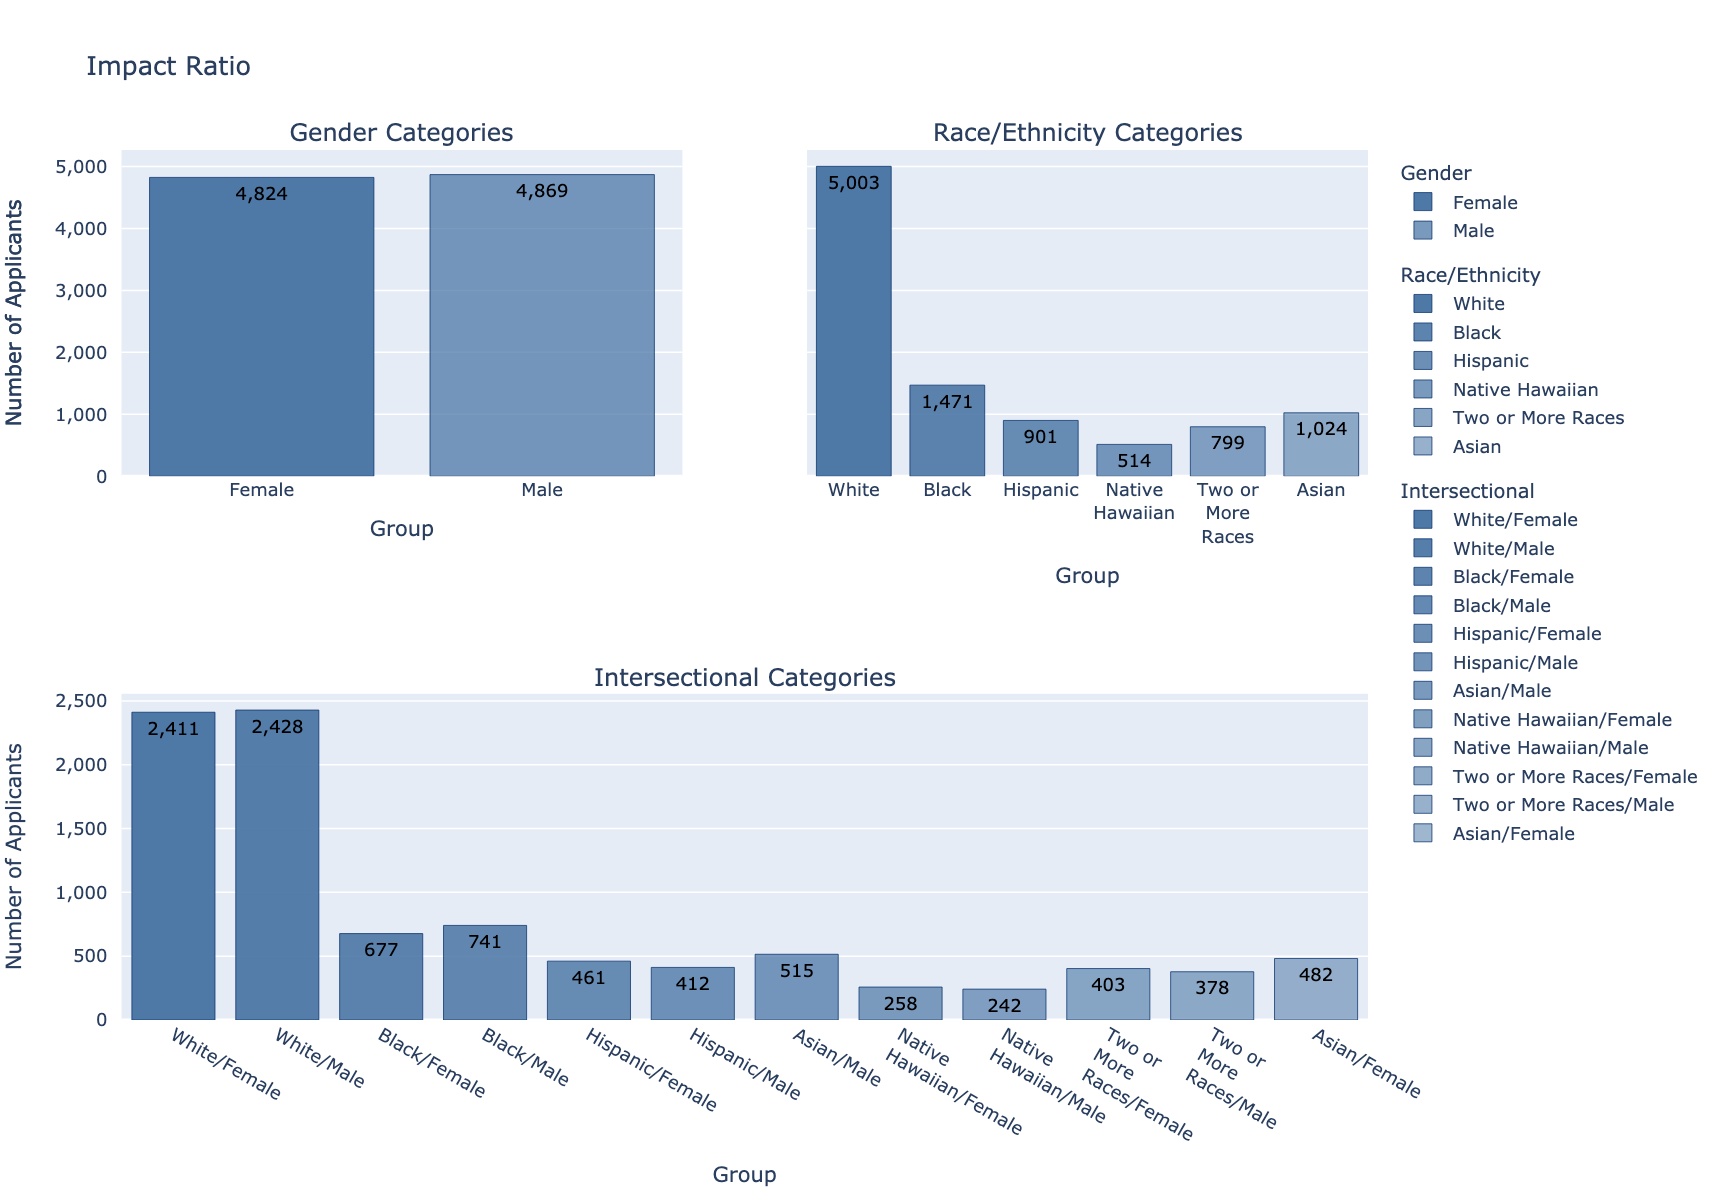

In [10]:
scoring_ir.plot(column="Number of Applicants")

The plot for a single group (gender, race/ethnicity, or intersectional) can also be viewed individually by setting the `group_category`. These are commented out for the sake of brevity in this notebook.

In [11]:
# scoring_ir.plot(column="Number of Applicants", group_category="Gender")
# scoring_ir.plot(column="Number of Applicants", group_category="Race/Ethnicity")
# scoring_ir.plot(column="Number of Applicants", group_category="Intersectional")

Local Law 144 allows for any group falling below 2% of the population to be excluded from the analysis. However, a table showing the number of applicants in each group and their associated scoring rate must be provided. The table is produced below.

In [12]:
scoring_ir.small_group_table

,Number of Applicants,Scoring Rate
Group,,
Native American,100.0,0.370000
Native American/Female,48.0,0.416667
Native American/Male,50.0,0.340000


Local Law 144 also requires a table showing the number of applicants for whom demographic information is unknown.

In [13]:
scoring_ir.unknown_table

,Total Unknown
Group Category,
Race/Ethnicity,188.0
Gender,307.0
Intersectional,494.0


### Reports

Local Law 144 requires that a table for the gender analysis, race/ethnicity analysis, and intersectional analysis be provided. Each is produced below.

In [14]:
gender_report, race_ethnicity_report, intersectional_report = scoring_ir.report

In [15]:
gender_report

,Number of Applicants,Number with Score Above Median,Scoring Rate,Impact Ratio
Group,,,,
Female,4824.0,2375.0,0.492330,0.972477
Male,4869.0,2465.0,0.506264,1.000000


In [16]:
race_ethnicity_report

,Number of Applicants,Number with Score Above Median,Scoring Rate,Impact Ratio
Group,,,,
White,5003.0,2357.0,0.471117,0.600777
Black,1471.0,679.0,0.461591,0.588629
Hispanic,901.0,424.0,0.470588,0.600103
Native Hawaiian,514.0,226.0,0.439689,0.560699
Two or More Races,799.0,390.0,0.488110,0.622447
Asian,1024.0,803.0,0.784180,1.000000


In [17]:
intersectional_report

,Number of Applicants,Number with Score Above Median,Scoring Rate,Impact Ratio
Group,,,,
White/Female,2411.0,1099.0,0.455827,0.563356
White/Male,2428.0,1178.0,0.485173,0.599624
Black/Female,677.0,302.0,0.446086,0.551316
Black/Male,741.0,350.0,0.472335,0.583757
Hispanic/Female,461.0,213.0,0.462039,0.571033
Hispanic/Male,412.0,200.0,0.485437,0.599950
Asian/Male,515.0,390.0,0.757282,0.935922
Native Hawaiian/Female,258.0,116.0,0.449612,0.555675
Native Hawaiian/Male,242.0,102.0,0.421488,0.520915


Each report is a pandas dataframe that can easily be saved using pandas functions.

In [18]:
# gender_report.to_csv('gender_report.csv')
# race_ethnicity_report.to_csv('race_ethnicity_report.csv')
# intersectional_report.to_csv('intersectional_report.csv')

# scoring_ir.small_group_table.to_csv('small_group_report.csv')
# scoring_ir.unknown_table.to_csv('unknown_report.csv')

### Plotting

Each of the above report can also be produced as a bar chart. The horizontal dashed line represents the `ratio_threshold` — 0.8 here. The bar for any group that falls below this threshold is hashed to indicate that it s a practically significant result.

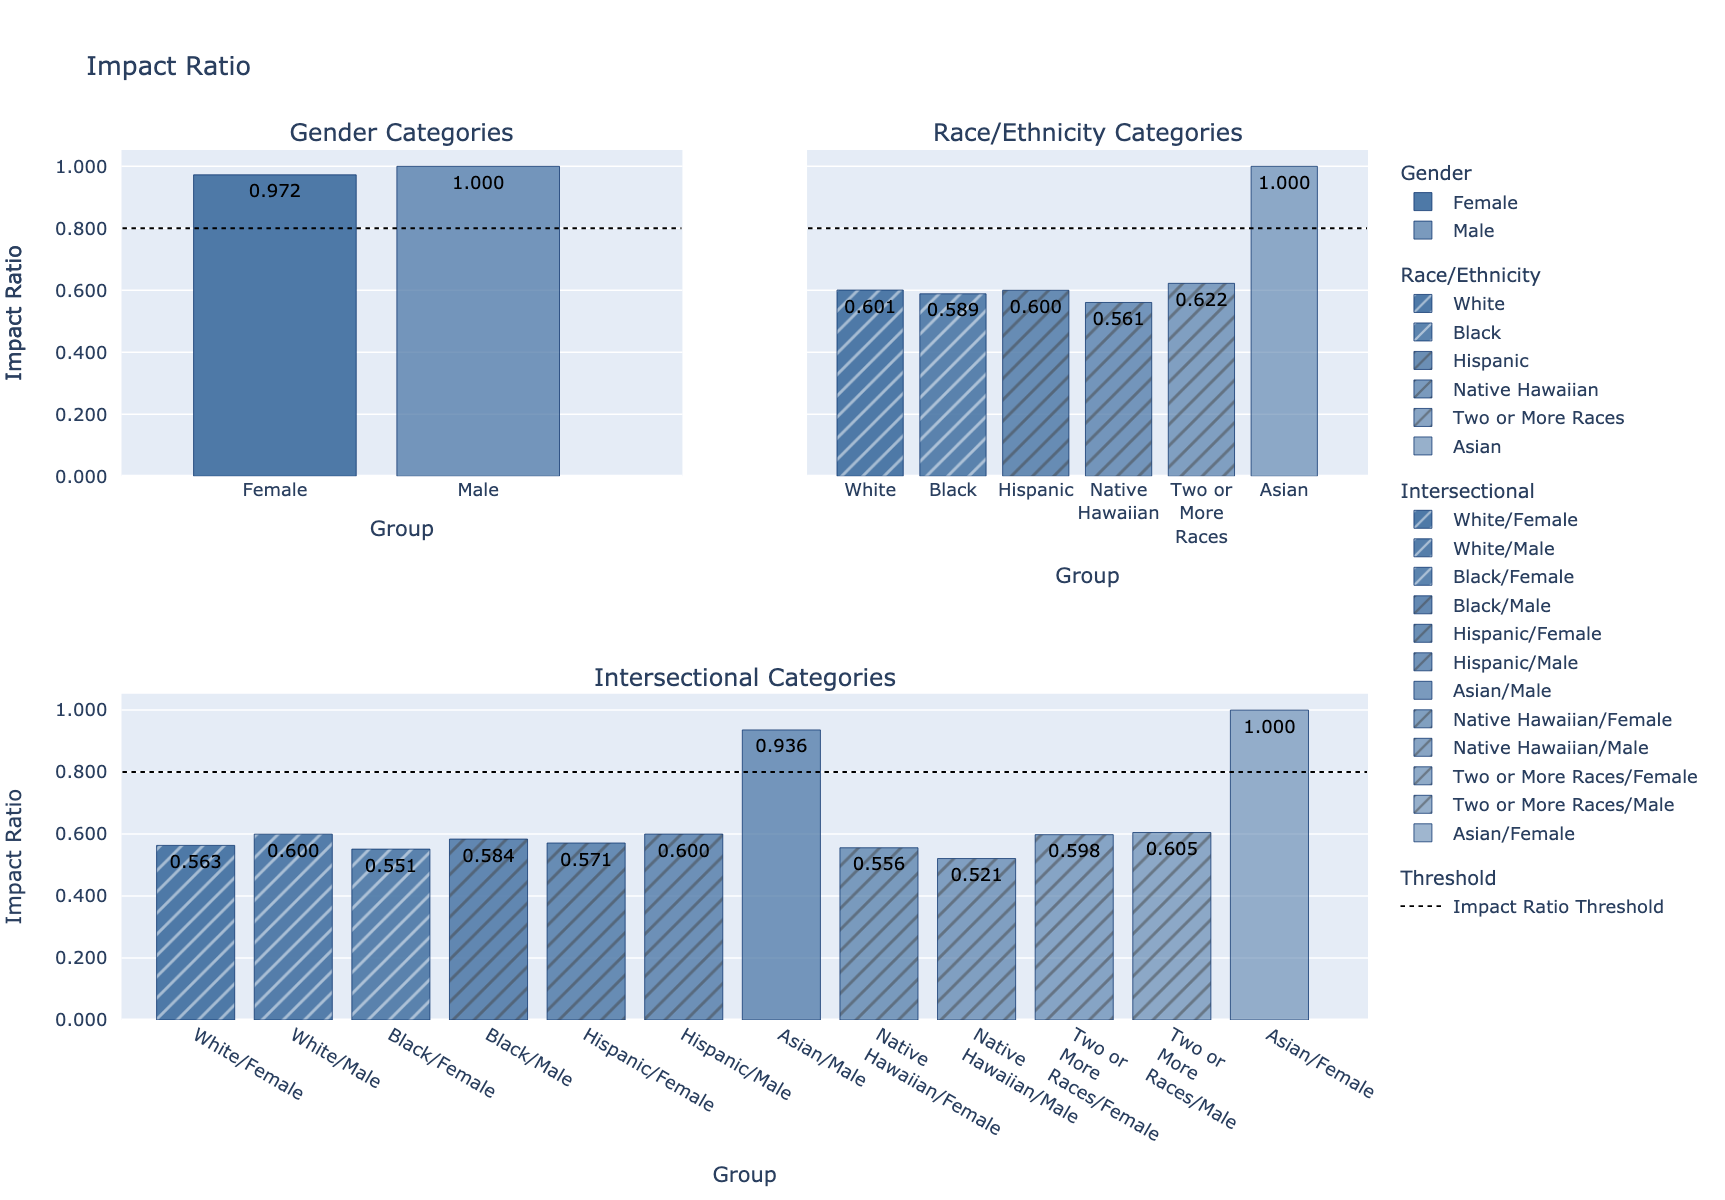

In [19]:
scoring_ir.plot()

Plots can also be viewed individually.

In [20]:
gender_plot, race_ethnicity_plot, intersectional_plot = scoring_ir.plot(separate=True)

# gender_plot
# race_ethnicity_plot
# intersectional_plot

Any plot can be saved by calling `write_image()` on it.

In [21]:
# gender_plot.write_image('scoring_impact_ratio_gender_plot.png')
# race_ethnicity_plot.write_image('scoring_impact_ratio_race_ethnicity_plot.png')
# intersectional_plot.write_image('scoring_impact_ratio_intersectional_plot.png')

### Summary table

A summary table containing more detailed information above and beyond what is required by Local Law 144 is also available. This table includes all information needed to calculate the scoring rate and scoring rate impact ratio in addition to measures of statistical and practical significance. Further explanation of these concepts can be found [here](https://github.com/SolasAI/solas-ai-disparity/blob/main/examples/01_solas-ai-disparity-introduction.ipynb).

In [22]:
# scoring_ir.summary_table

## Selection Impact Ratio

We now turn to the selection impact ratio. To call the function, we pass the dataset, a list of the race and ethnicity columns, the gender columns, and the column containing the automated employment decision tool's recommendation (0 for negative outcome and 1 for a positive outcome, from the perspective of the applicant). Additional more technical parameters are available. 
* `ratio_threshold` is the value a scoring impact ratio must fall below to be considered practically significant
* `difference_threshold` is the minimum difference in scores to be considered practically significant
* `sample_weight` (optional) sample weights for rows in the dataset
* `drop_small_groups` whether to drop groups that fall below 2% of the population, pursuant to Local Law 144

In [23]:
selection_ir = sd.selection_impact_ratio(
    group_data=group_data,
    race_ethnicity_groups=["White", "Black", "Hispanic", "Asian", "Native Hawaiian", "Native American", "Two or More Races"],
    gender_groups=["Female", "Male"],
    outcome=data['Selection'],
    ratio_threshold=0.8,
    difference_threshold=0.0,
    sample_weight=None,
    drop_small_groups=True,
)

The `selection_ir` object has all the various reporting requirements attached to it. To see them all at once, the following cell can be uncommented. We will examine each report in turn.

In [24]:
#selection_ir

### Group Counts

As above, the counts of applicants for each demographic group can be shown together or separately.

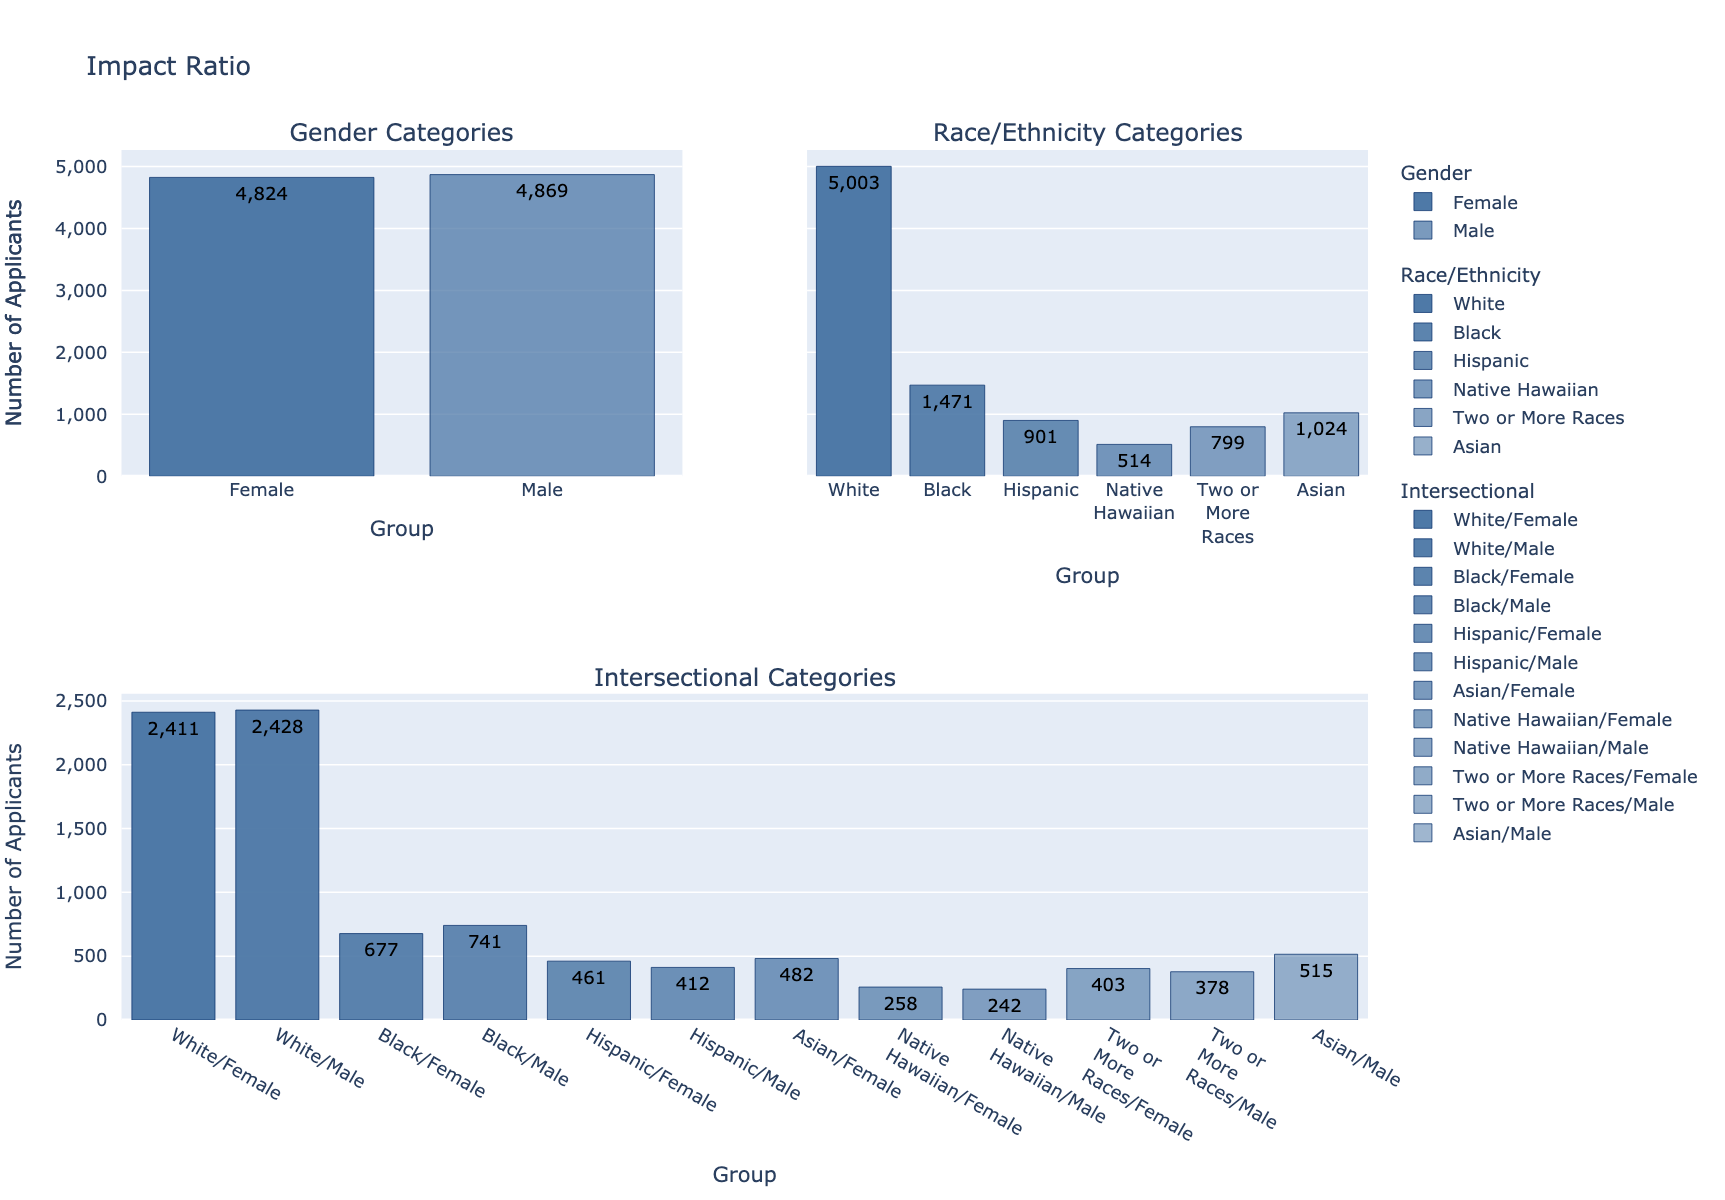

In [25]:
selection_ir.plot(column="Number of Applicants")

# selection_ir.plot(column="Number of Applicants", group_category="Gender")
# selection_ir.plot(column="Number of Applicants", group_category="Race/Ethnicity")
# selection_ir.plot(column="Number of Applicants", group_category="Intersectional")

Local Law 144 allows for any group falling below 2% of the population to be excluded from the analysis. However, a table showing the number of applicants in each group and their associated scoring rate must be provided. The table is produced below.

In [26]:
selection_ir.small_group_table

,Number of Applicants,Selection Rate
Group,,
Native American,100.0,0.950000
Native American/Female,48.0,0.958333
Native American/Male,50.0,0.940000


Local Law 144 also requires a table showing the number of applicants for whom demographic information is unknown. An individual's demographic information is unknown if all race/ethnicity columns are 0s or each gender column contains a 0.

In [27]:
selection_ir.unknown_table

,Total Unknown
Group Category,
Race/Ethnicity,188.0
Gender,307.0
Intersectional,494.0


### Reports

Local Law 144 requires that a table for the gender analysis, race/ethnicity analysis, and intersectional analysis be provided. Each is produced below.

In [28]:
gender_report, race_ethnicity_report, intersectional_report = selection_ir.report

In [29]:
gender_report

,Number of Applicants,Number Selected,Selection Rate,Impact Ratio
Group,,,,
Female,4824.0,3589.0,0.743988,0.983835
Male,4869.0,3682.0,0.756213,1.000000


In [30]:
race_ethnicity_report

,Number of Applicants,Number Selected,Selection Rate,Impact Ratio
Group,,,,
White,5003.0,3474.0,0.694383,0.698476
Black,1471.0,1017.0,0.691366,0.695441
Hispanic,901.0,717.0,0.795782,0.800473
Native Hawaiian,514.0,488.0,0.949416,0.955012
Two or More Races,799.0,559.0,0.699625,0.703748
Asian,1024.0,1018.0,0.994141,1.000000


In [31]:
intersectional_report

,Number of Applicants,Number Selected,Selection Rate,Impact Ratio
Group,,,,
White/Female,2411.0,1657.0,0.687267,0.691294
White/Male,2428.0,1702.0,0.700988,0.705096
Black/Female,677.0,463.0,0.683900,0.687907
Black/Male,741.0,516.0,0.696356,0.700436
Hispanic/Female,461.0,360.0,0.780911,0.785487
Hispanic/Male,412.0,338.0,0.820388,0.825195
Asian/Female,482.0,479.0,0.993776,0.999599
Native Hawaiian/Female,258.0,246.0,0.953488,0.959075
Native Hawaiian/Male,242.0,229.0,0.946281,0.951826


### Plots

We can also view all plots at once.

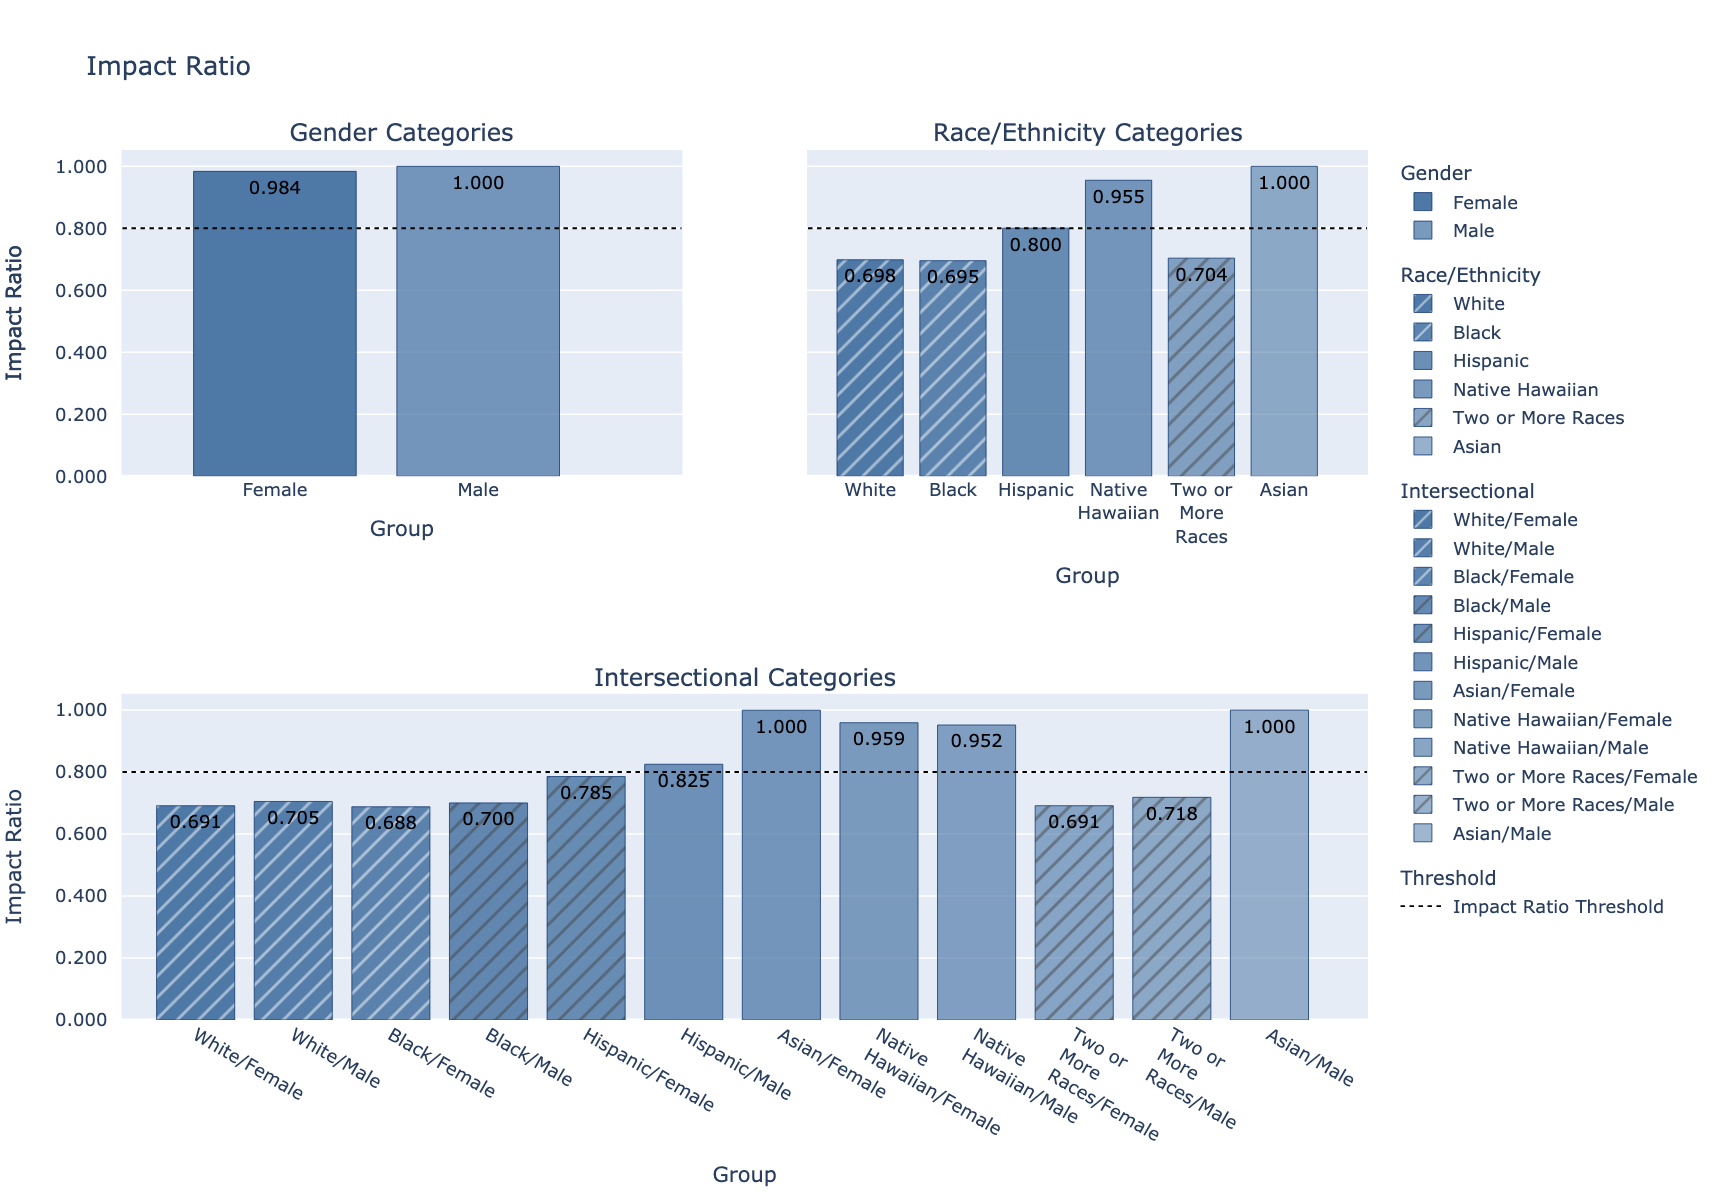

In [32]:
selection_ir.plot()

### Summary table

A summary table containing more detailed information above and beyond what is required by Local Law 144 is also available. This table includes all information needed to calculate the scoring rate and scoring rate impact ratio in addition to measures of statistical and practical significance. Further explanation of these concepts can be found [here](https://github.com/SolasAI/solas-ai-disparity/blob/main/examples/01_solas-ai-disparity-introduction.ipynb).

In [33]:
# selection_ir.summary_table

# Conclusion

The functions included in the SolasAI Disparity and Bias Testing Library have been designed to comply with Local Law 144 and provide all the various reporting requirements of the law while maintaining an easy-to-use interface. With these tools, a user with minimal knowledge of Python will be able to generate full reports in compliance with Local Law 144.